## Task 1: Image Classification with CNN 
inspired from AlexNet,not perfectly tuned

In [7]:
import torch
import sklearn
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics
import matplotlib.pyplot as plt

f1_score = sklearn.metrics.f1_score
confusion_matrix = sklearn.metrics.confusion_matrix



# Define a custom dataset class
class ImageDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return dict(X=img, y=label)

    def __len__(self):
        return len(self.dataset)

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(ImageDataset(train_dataset), batch_size=32, shuffle=True)
test_loader = DataLoader(ImageDataset(test_dataset), batch_size=32, shuffle=False)

# Check number of classes in the dataset
num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')


Files already downloaded and verified
Files already downloaded and verified
Number of classes: 100


In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1), # 3 126 126
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 32 62 62
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  #64 62 62
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #64 30 30
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #128 30 30
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # 128 14 14
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        output = self.features(x)
        #output = self.avgpool(output)#
        output = torch.flatten(output, 1)
        output = self.classifier(output)
        return output
#
# Initialize the model
model_1 = CNN()
model_2 = CNN()

In [9]:
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix , f1_score
def train_model(model, criterion, optimizer, train_loader, num_epochs, device):
  model.to(device)
  model.train()


  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
      inputs = batch['X'].float().to(device)
      labels = batch['y'].long().to(device)
      optimizer.zero_grad()
      output= model(inputs)
      loss = criterion(output , labels)
      loss.backward()
      optimizer.step()
      epoch_loss+= loss.item()

    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')
  print('Training is complete')

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
learning_rate= 0.01
optimizer = optimizer = optim.SGD(model_2.parameters(), lr=learning_rate, momentum=0.9 , weight_decay=5e-4)
num_epochs = 15
train_model(model_2, criterion, optimizer, train_loader,  num_epochs, device)


Epoch 1/15, Loss: 3.3532576589956546
Epoch 2/15, Loss: 2.6096172749195357
Epoch 3/15, Loss: 2.271506994943625
Epoch 4/15, Loss: 2.0342782047873342
Epoch 5/15, Loss: 1.844070894323094
Epoch 6/15, Loss: 1.683641949869926
Epoch 7/15, Loss: 1.53728995381146
Epoch 8/15, Loss: 1.3938798127995038
Epoch 9/15, Loss: 1.2725013207336762
Epoch 10/15, Loss: 1.1725679504055284
Epoch 11/15, Loss: 1.0711011059834876
Epoch 12/15, Loss: 0.9787610868803599
Epoch 13/15, Loss: 0.9160057450439102
Epoch 14/15, Loss: 0.8408644420171654
Epoch 15/15, Loss: 0.776898493846105
Training is complete


In [10]:
torch.save(model_2.state_dict() , 'trained_model.pth')

In [11]:
model_2.load_state_dict(torch.load('trained_model.pth'))
def evaluate_model(model, test_loader, device):
  model.to(device)
  model.eval()
  predictions =[]
  true_labels =[]
  classes = test_loader.dataset.dataset.classes
  with torch.no_grad():
    for batch in test_loader:
      X_test , y_test = batch['X'].float().to(device) , batch['y'].long().to(device)
      output = model(X_test)
      _ , preds = torch.max(output,1)
      preds = preds.cpu().numpy()
      y_test = y_test.cpu().numpy()
      predictions.extend(preds)
      true_labels.extend(y_test)
  accuracy = accuracy_score(true_labels , predictions)
  f1 = f1_score(true_labels, predictions , average='weighted')
  test_error = 1 - accuracy
  print(f'Accuracy {accuracy:.4f}, F1 score : {f1:.4f} , test_error : {(1-accuracy):.4f}')

  cm = confusion_matrix(true_labels , predictions)
  plt.figure(figsize=(10,8))
  plt.imshow(cm, interpolation ='nearest', cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.tight_layout()
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Label')
  plt.show()

  return accuracy, f1, test_error, cm, classes

Accuracy 0.4554, F1 score : 0.4564 , test_error : 0.5446


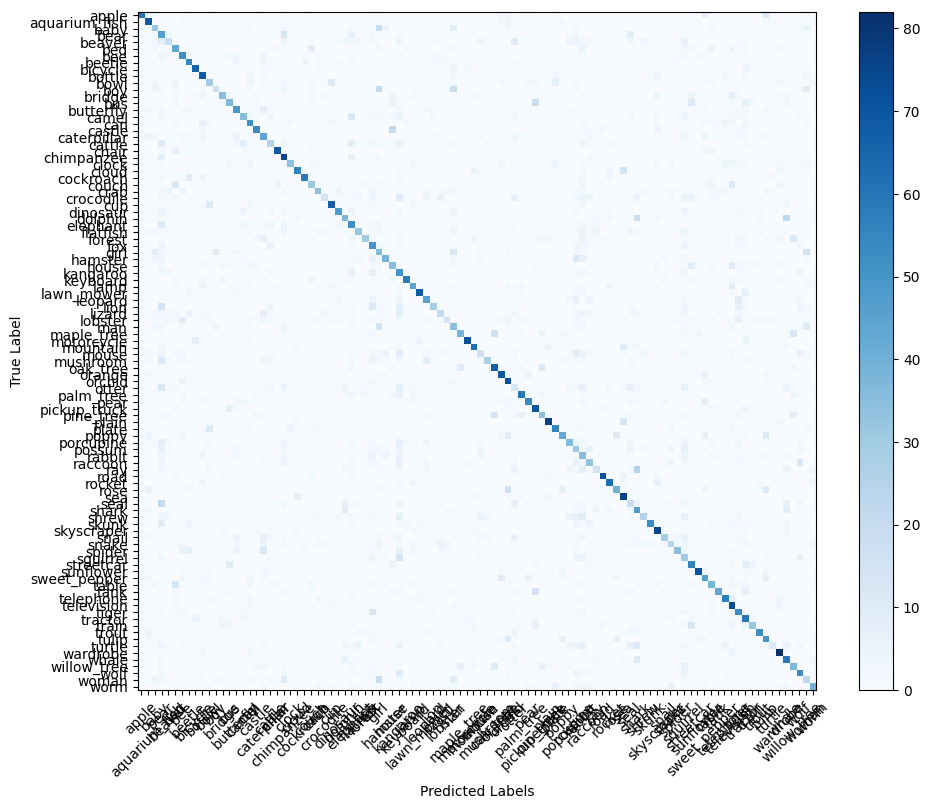

In [13]:
# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accuracy, f1, test_error, cm, classes = evaluate_model(model_2, test_loader, device)